In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
sia = SentimentIntensityAnalyzer()
STOPWORDS = set(stopwords.words('english'))
from autocorrect import Speller
spell = Speller()
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from wordcloud import WordCloud
import pickle
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\v-bmangheni\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
#Read the csv data and saving it into a data frame and then check the general structure of the data
data = pd.read_csv("./data/data.csv")
data.head(2)

C:\Users\v-bmangheni\AppData\Local\Temp\ipykernel_15380\2169224654.py:2: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("./data/data.csv")


,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,...,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,This product so far has not disappointed. My c...,Kindle,NaN,NaN,Adapter
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,great for beginner or experienced person. Boug...,very fast,NaN,NaN,truman


In [5]:
#Since we are only interested in sentiment analysis we will only use reviews.text and reviews.rating
data = data[["reviews.text", "reviews.rating"]]
data.head()

,reviews.text,reviews.rating
0,This product so far has not disappointed. My c...,5.0
1,great for beginner or experienced person. Boug...,5.0
2,Inexpensive tablet for him to use and learn on...,5.0
3,I've had my Fire HD 8 two weeks now and I love...,4.0
4,I bought this for my grand daughter when she c...,5.0


In [6]:
#Checking null values: 34 in total
data.isnull().sum()

reviews.text       1
reviews.rating    33
dtype: int64

In [8]:
#Drop the null values and then re-assign data to cleaned version of data
data = data.dropna()

In [74]:
# Checking to confirm the null values have been removed
data.isna().sum()

reviews.text          0
reviews.rating        0
sentiment_score       0
sentiment             0
length             3101
dtype: int64

In [11]:
# Checking the data types for the text and ratings columns, which is String and float.
data.dtypes

reviews.text       object
reviews.rating    float64
dtype: object

In [12]:
# This function map out sentiment scores and sentiment labels according to the rating 

def map_sentiments(data_param):
    # Initialize new columns for sentiment_score and sentiment
    data_param["sentiment_score"] = 0
    data_param["sentiment"] = ""

    for index, row in data_param.iterrows():
        rating = row["reviews.rating"]

        # Determine sentiment_score based on reviews.rating
        if rating == 1 or rating == 2:
            sentiment_score = 0
        elif rating == 3:
            sentiment_score = 1
        elif rating == 4 or rating == 5:
            sentiment_score = 2

        # Determine sentiment based on sentiment_score
        if sentiment_score == 0:
            sentiment = "NEGATIVE"
        elif sentiment_score == 1:
            sentiment = "NEUTRAL"
        elif sentiment_score == 2:
            sentiment = "POSITIVE"

        # Assign the calculated values to the DataFrame
        data_param.at[index, "sentiment_score"] = sentiment_score
        data_param.at[index, "sentiment"] = sentiment

    return data_param



In [13]:
# We then create a new column to hold the length of text reviews submitted, we can use this to co-relate the length of the feedback to the ratings i.e Happy customers would submit longer reviews
data["length"] = data["reviews.text"].apply(len)
# We then map ratings to sentiment scores and sentiments
data = map_sentiments(data)

In [14]:
#Check the shape of the data after adding the two columns
data.head(10)

,reviews.text,reviews.rating,length,sentiment_score,sentiment
0,This product so far has not disappointed. My c...,5.0,143,2,POSITIVE
1,great for beginner or experienced person. Boug...,5.0,75,2,POSITIVE
2,Inexpensive tablet for him to use and learn on...,5.0,131,2,POSITIVE
3,I've had my Fire HD 8 two weeks now and I love...,4.0,593,2,POSITIVE
4,I bought this for my grand daughter when she c...,5.0,613,2,POSITIVE
5,This amazon fire 8 inch tablet is the perfect ...,5.0,209,2,POSITIVE
6,"Great for e-reading on the go, nice and light ...",4.0,115,2,POSITIVE
7,"I gave this as a Christmas gift to my inlaws, ...",5.0,132,2,POSITIVE
8,Great as a device to read books. I like that i...,5.0,267,2,POSITIVE
9,I love ordering books and reading them with th...,5.0,55,2,POSITIVE


In [15]:
# Analyzing the rating column
data["sentiment_score"].value_counts()

sentiment_score
2    32315
1     1499
0      812
Name: count, dtype: int64

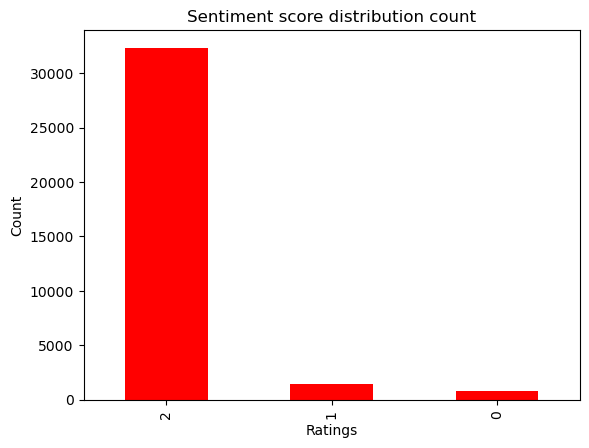

In [16]:
data['sentiment_score'].value_counts().plot.bar(color = 'red')
plt.title('Sentiment score distribution count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

In [17]:
#To solve the huge imbalance in the number of feedback with higher ratings and lower ratings. This make sure the model will get a balanced proportion of data for different sentiments

data1 = pd.read_csv("./data/data1.csv")
data1 = data1[["reviews.text", "reviews.rating"]]
# Read data1.csv and data2.csv and Use only lower ratings
data1 = data1[data1["reviews.rating"] <= 3]
data1 = map_sentiments(data1)



data2 = pd.read_csv("./data/data2.csv")
data2 = data2[["reviews.text", "reviews.rating"]]
# Use only lower ratings
data2 = data2[data2["reviews.rating"] <= 3]
data2 = map_sentiments(data2)

# Sample only 4000 positive reviews from the first data frame
data = pd.concat([data1,data2, data.sample(4000, random_state=43)]).sample(frac=1).reset_index(drop=True)
data["sentiment_score"].value_counts()
data.shape

(7101, 5)

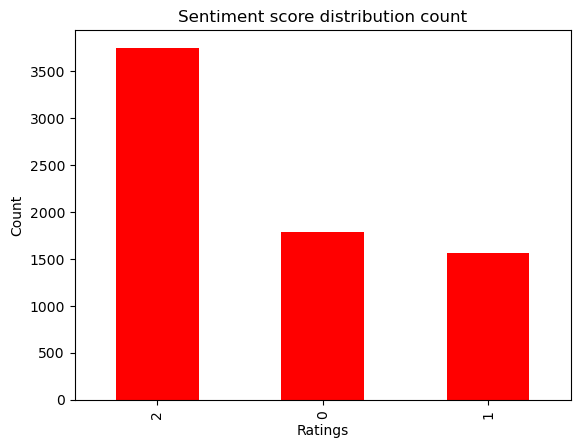

In [18]:
#Bar plot to visualize the total counts of each rating which is better balanced now

data['sentiment_score'].value_counts().plot.bar(color = 'red')
plt.title('Sentiment score distribution count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

c:\Users\v-bmangheni\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[Text(0.5, 1.0, 'Distribution of length of review ')]

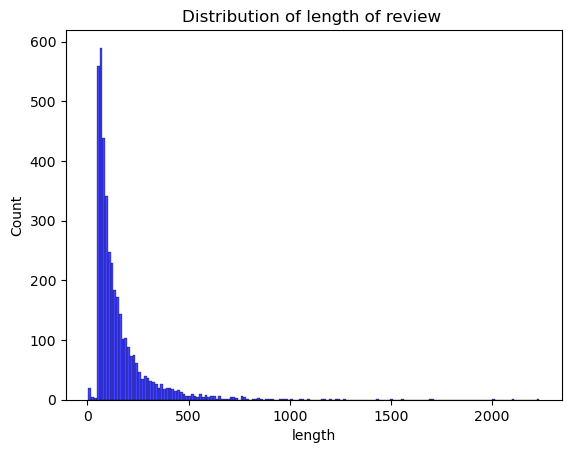

In [20]:
#The histogram shows that the majority of reviews are short, with a rapidly decreasing number of longer reviews.
sns.histplot(data['length'],color='blue').set(title='Distribution of length of review ')


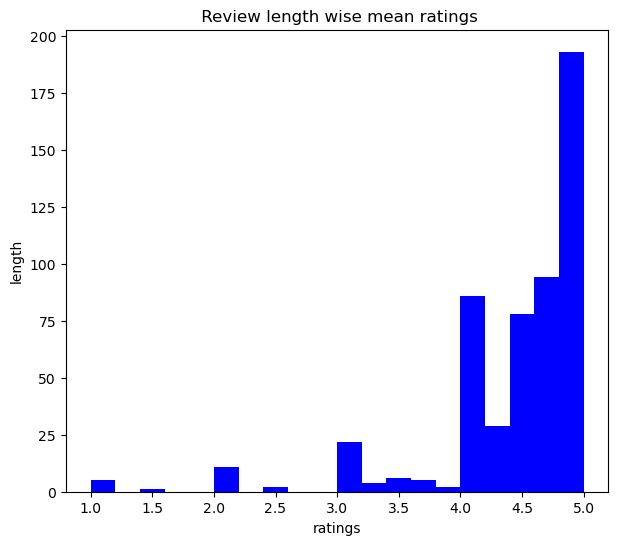

In [21]:
#Positive ratings have the longest average reviews
data.groupby('length')['reviews.rating'].mean().plot.hist(color = 'blue', figsize=(7, 6), bins = 20)
plt.title(" Review length wise mean ratings")
plt.xlabel('ratings')
plt.ylabel('length')
plt.show()

In [22]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data["reviews.text"])

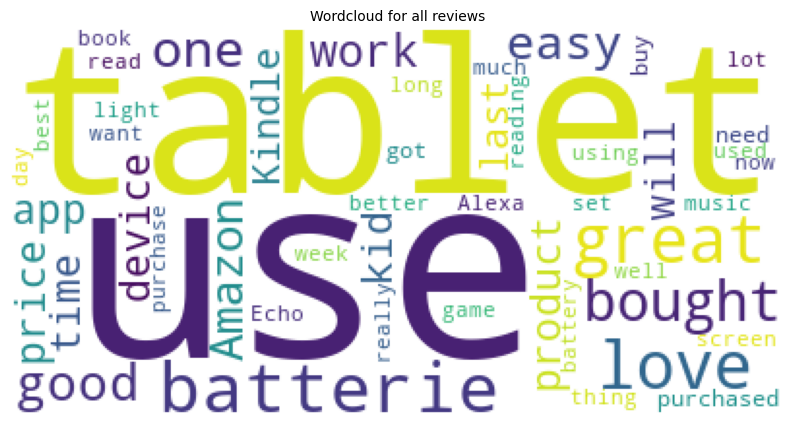

In [23]:
# Wordcloud for all words in data
# Combine all reviews
reviews = " ".join([review for review in data['reviews.text']])
                        
# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

In [24]:
# Combine all reviews for each feedback category and splitting them into individual words
neg_reviews = " ".join([review for review in data[data['sentiment_score'] == 0]['reviews.text']])
neg_reviews = neg_reviews.lower().split()

neutral_reviews = " ".join([review for review in data[data['sentiment_score'] == 1]['reviews.text']])
neutral_reviews = neutral_reviews.lower().split()

pos_reviews = " ".join([review for review in data[data['sentiment_score'] == 2]['reviews.text']])
pos_reviews = pos_reviews.lower().split()

#Finding words from reviews which are present in that feedback category only
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

unique_neutral = [x for x in neg_reviews if x not in neutral_reviews]
unique_neutral = " ".join(unique_neutral)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)

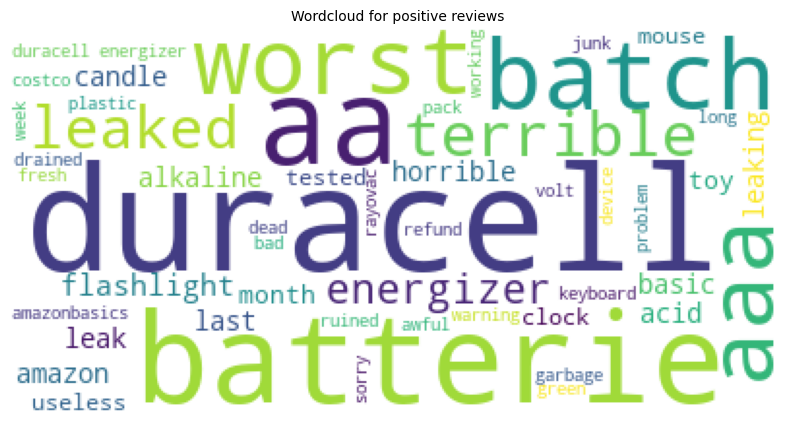

In [25]:
#Negative words
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()

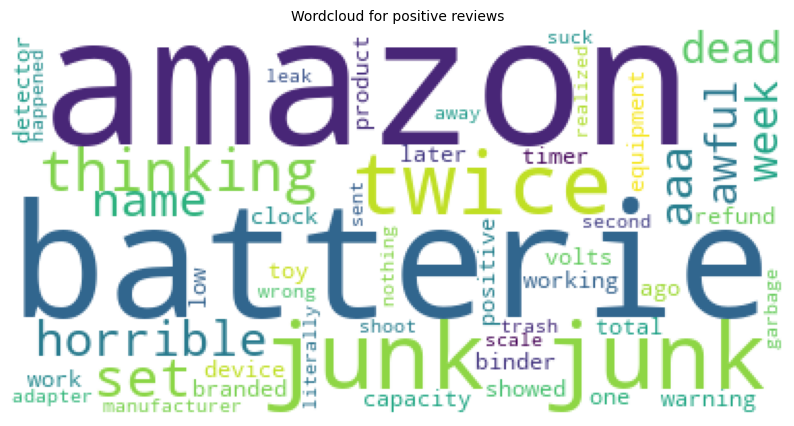

In [26]:
#Neutral words
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_neutral))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()

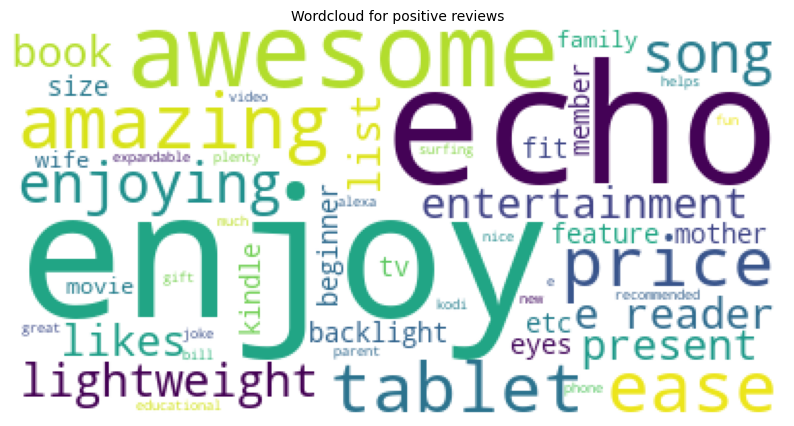

In [27]:
#Positive words
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()

In [28]:
corpus = []
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

corpus = []
stemmer = PorterStemmer()
for i in range(0, data.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['reviews.text'])
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
  review = ' '.join(review)
  corpus.append(review)

In [29]:
cv = CountVectorizer(max_features = 2500)

#Storing independent and dependent variables in X and y
X = cv.fit_transform(corpus).toarray()
y = data['sentiment_score'].values

In [30]:
#Saving the Count Vectorizer
pickle.dump(cv, open('Models/countVectorizer.pkl', 'wb'))

In [31]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (7101, 2500)
y shape: (7101,)


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 15)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (5680, 2500)
y train: (5680,)
X test: (1421, 2500)
y test: (1421,)


In [33]:
print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")

X train max value: 16
X test max value: 14


In [34]:
scaler = MinMaxScaler()


X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [35]:
#Saving the scaler model
pickle.dump(scaler, open('Models/scaler.pkl', 'wb'))

In [36]:
model_lr = LogisticRegression()
model_lr.fit(X_train_scl, y_train)

LogisticRegression()

In [37]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_lr.score(X_train_scl, y_train))
print("Testing Accuracy :", model_lr.score(X_test_scl, y_test))

Training Accuracy : 0.9144366197183098
Testing Accuracy : 0.8219563687543983


In [38]:
y_preds = model_lr.predict(X_test)


In [39]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[270  29  51]
 [ 74 131 112]
 [ 10  32 712]]


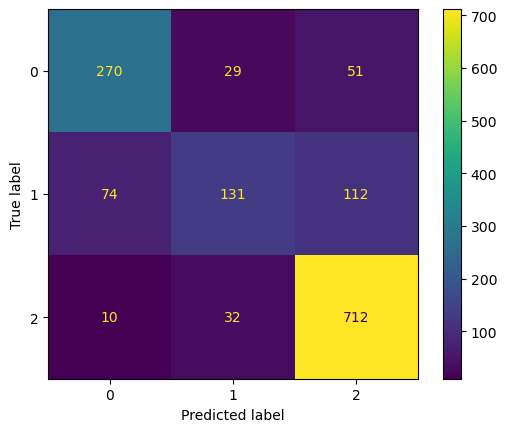

In [40]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_lr.classes_)
cm_display.plot()
plt.show()

In [41]:
pickle.dump(model_lr, open('Models/model_xgb.pkl', 'wb'))

Making test predictions and graphing the sentiment ditributions

In [42]:
def sentiment_mapping(x):
    if x == 0:
        return "NEGATIVE"
    elif x == 1:
        return "NEUTRAL"
    else:
        return "POSITIVE"

In [50]:
def sentiment_score_mapping(x):
    if x == "NEGATIVE":
        return 0
    elif x == "NEUTRAL":
        return 1
    else:
        return 2

In [52]:
def bulk_prediction(predictor, scaler, cv, data):
    corpus = []
    stemmer = PorterStemmer()

    for i in range(data.shape[0]):
        # Convert each entry to a string and handle missing values
        review = str(data.iloc[i]["reviews.text"])
        
        # Skip any empty strings that result from conversion of NaN or other non-string values
        if review.strip() == '':
            continue
        
        review = re.sub("[^a-zA-Z]", " ", review)
        review = review.lower().split()
        review = [stemmer.stem(word) for word in review if word not in STOPWORDS]
        review = " ".join(review)
        corpus.append(review)


    X_prediction = cv.transform(corpus).toarray()
    X_prediction_scl = scaler.transform(X_prediction)
    y_predictions = predictor.predict_proba(X_prediction_scl)
    y_predictions = y_predictions.argmax(axis=1)

    y_predictions = list(map(sentiment_mapping, y_predictions))

    data["Predicted sentiment"] = y_predictions
    return data


In [80]:
newdf = pd.read_csv("./data/data1.csv", low_memory=False)
predictedData = pd.DataFrame(bulk_prediction(model_lr, scaler, cv, newdf)) 
predictedData = predictedData[["categories","reviews.text", "reviews.rating", "Predicted sentiment"]]
predictedData["sentiment_score"] = predictedData["Predicted sentiment"].map(sentiment_score_mapping)

predictedData.head(10)

,categories,reviews.text,reviews.rating,Predicted sentiment,sentiment_score
0,"AA,AAA,Health,Electronics,Health & Household,C...",I order 3 of them and one of the item is bad q...,3,NEGATIVE,0
1,"AA,AAA,Health,Electronics,Health & Household,C...",Bulk is always the less expensive way to go fo...,4,POSITIVE,2
2,"AA,AAA,Health,Electronics,Health & Household,C...",Well they are not Duracell but for the price i...,5,POSITIVE,2
3,"AA,AAA,Health,Electronics,Health & Household,C...",Seem to work as well as name brand batteries a...,5,NEUTRAL,1
4,"AA,AAA,Health,Electronics,Health & Household,C...",These batteries are very long lasting the pric...,5,NEUTRAL,1
5,"AA,AAA,Health,Electronics,Health & Household,C...",Bought a lot of batteries for Christmas and th...,5,NEUTRAL,1
6,"AA,AAA,Health,Electronics,Health & Household,C...",ive not had any problame with these batteries ...,5,NEGATIVE,0
7,"AA,AAA,Health,Electronics,Health & Household,C...",Well if you are looking for cheap non-recharge...,5,NEUTRAL,1
8,"AA,AAA,Health,Electronics,Health & Household,C...",These do not hold the amount of high power jui...,3,NEUTRAL,1
9,"AA,AAA,Health,Electronics,Health & Household,C...",AmazonBasics AA AAA batteries have done well b...,4,NEGATIVE,0


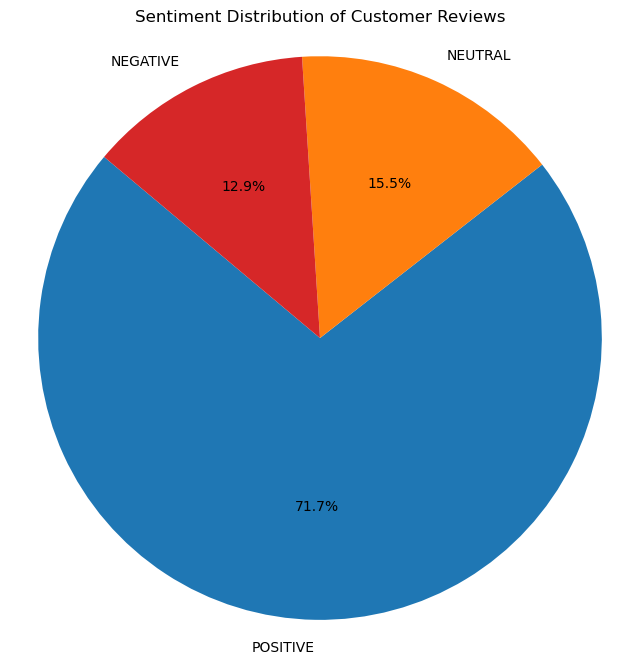

In [81]:
sentiment_counts = predictedData["Predicted sentiment"].value_counts()
# Extracting the labels and values
labels = sentiment_counts.index
sizes = sentiment_counts.values

# Define the colors for each sentiment
colors = ['#1f77b4', '#ff7f0e', '#d62728']  # Blue for positive, orange for neutral, red for negative

# Creating the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors[:len(labels)], autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Distribution of Customer Reviews')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.

# Display the pie chart
plt.show()

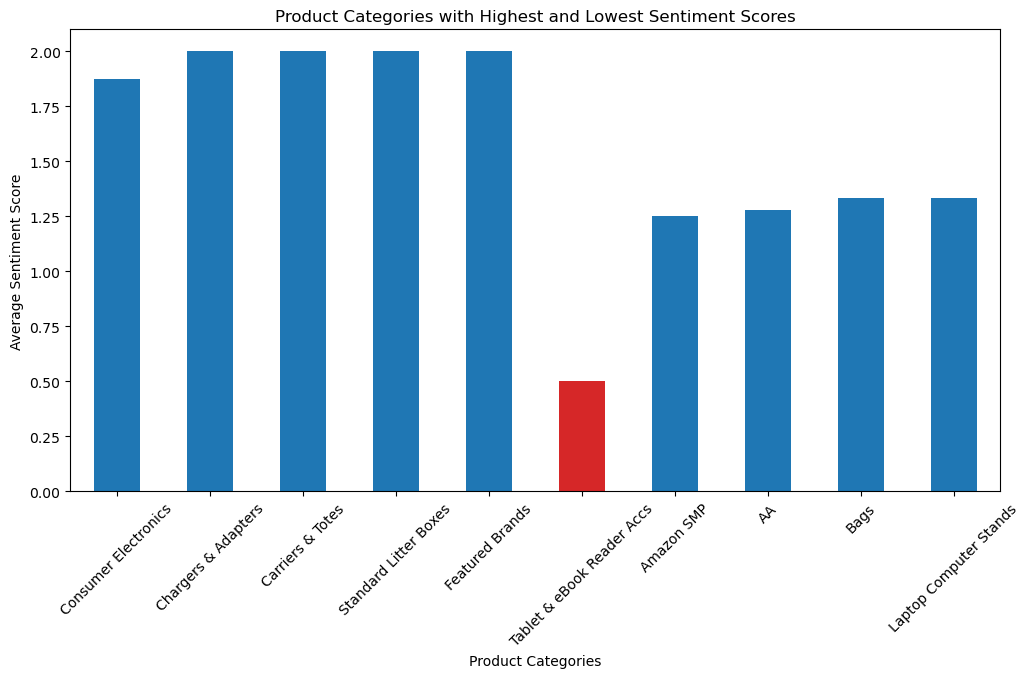

In [82]:
# Split the categories into individual components
predictedData['main_category'] = predictedData['categories'].apply(lambda x: x.split(',')[0])

# Group by main categories and calculate the average sentiment score
category_sentiment = predictedData.groupby('main_category')['sentiment_score'].mean().sort_values()

# Get the top and bottom categories
top_categories = category_sentiment.tail(5)
bottom_categories = category_sentiment.head(5)

# Combine the top and bottom categories for visualization
categories_to_plot = pd.concat([top_categories, bottom_categories])

# Plotting the bar chart
plt.figure(figsize=(12, 6))
categories_to_plot.plot(kind='bar', color=['#1f77b4' if score > 1 else '#d62728' for score in categories_to_plot])
plt.title('Product Categories with Highest and Lowest Sentiment Scores')
plt.xlabel('Product Categories')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45)
plt.show()